In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from itertools import product
from tqdm.notebook import tqdm
#!pip install ipywidgets

from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import seaborn as sns
from IPython.display import Video
import os
import pandas as pd

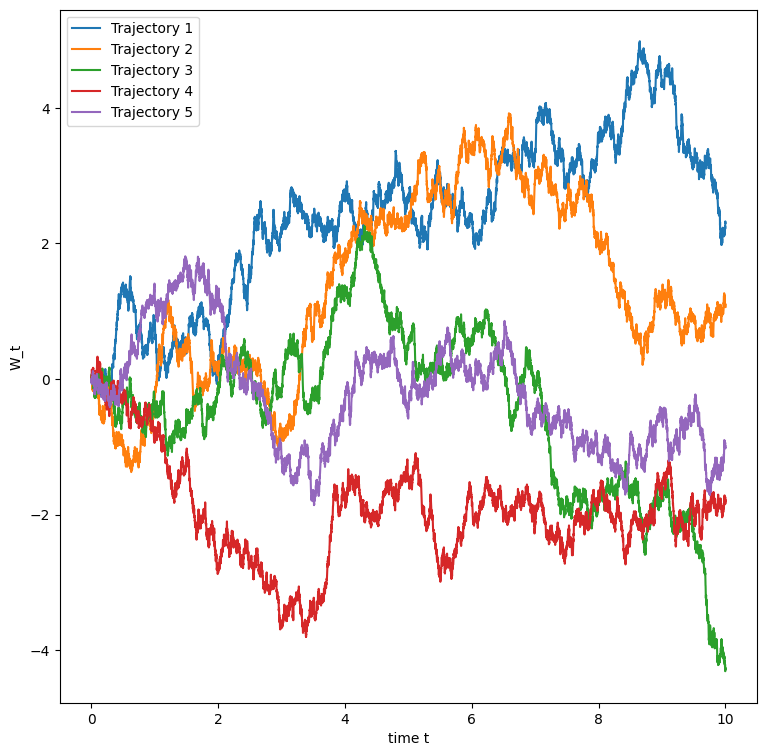

In [2]:
def run_brownian_motion(n_traj: int = 5, n_grid_points: int = 10000, t_start: float = 0.0, t_end: float = 10.0):
    time_grid = np.linspace(t_start,t_end,n_grid_points)
    grid_size = (t_end-t_start)/n_grid_points
    x_0 = np.array([n_traj*[0.0]])
    gaussian_noise = np.random.normal(size=(len(time_grid)-1,n_traj))
    brownian_motion = np.sqrt(grid_size)*gaussian_noise.cumsum(axis=0)
    brownian_motion = np.concatenate([x_0,brownian_motion],axis=0)
    return time_grid,brownian_motion

fig,ax = plt.subplots(figsize=(9,9))
time,X_t = run_brownian_motion()
sample_labels = [f"Trajectory {i}" for i in range(1,6)]
ax.plot(time,X_t,label=sample_labels)
ax.set_xlabel("time t")
ax.set_ylabel("W_t")
ax.legend();

In [3]:
def run_sde(f_determ_drift: Callable,
            g_random_drift: Callable,
            x_start: np.array,
            t_start: float = 0.0, 
            t_end: float = 1.0, 
            n_steps: int = 10000,
            **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    
    #Number of trajectories, dimension of data:
    n_traj,dim_x = x_start.shape

    #Compute time grid for discretization and step size:
    time_grid = np.linspace(t_start,t_end,n_steps)
    step_size = time_grid[1]-time_grid[0]

    #Compute the random drift at every time point:
    random_drift_grid = g_random_drift(time_grid)
    
    #Sample random drift at every time point:
    noise = np.random.normal(size=(n_steps,n_traj,dim_x))
    random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise
    
    #Initialize list of trajectory:
    x_traj = [x_start]
    
    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = float(time_grid[idx])
        
        #Get deterministic drift and random drift sample
        determ_drift = step_size*f_determ_drift(x,t)
        random_drift_sample = random_drift_grid_sample[idx]
        
        #Compute next step:
        next_step = x + determ_drift + random_drift_sample
        
        #Save step:
        x_traj.append(next_step)

    return np.stack(x_traj),time_grid    

In [22]:
def run_JD_sde(f_determ_drift: Callable,
            g_random_drift: Callable,
            h_random_drift: Callable,  #h(X_t,t)
            poisson_lamda: float,
            x_start: np.array,
            t_start: float = 0.0, 
            t_end: float = 1.0, 
            n_steps: int = 10000,
            **kwargs):
    """Function to run stochastic differential equation. We assume a deterministic initial distribution p_0."""
    
    #Number of trajectories, dimension of data:
    n_traj,dim_x = x_start.shape

    #Compute time grid for discretization and step size:
    time_grid = np.linspace(t_start,t_end,n_steps)
    step_size = time_grid[1]-time_grid[0]

    #poisson jumps each of size 1
    jump_occurred = np.random.poisson(lam=poisson_lamda*step_size, size=(n_steps,n_traj,dim_x))>0

    #Compute the random drift at every time point:
    random_drift_grid = g_random_drift(time_grid)
    
    #Sample random drift at every time point:
    noise = np.random.normal(size=(n_steps,n_traj,dim_x))
    random_drift_grid_sample = np.sqrt(step_size)*random_drift_grid[:,None,None]*noise
    
    #Initialize list of trajectory:
    x_traj = [x_start]
    
    
    for idx,time in tqdm(enumerate(time_grid)):
        
        #Get last location and time
        x = x_traj[idx]
        t = float(time_grid[idx])
        
        #Get deterministic drift and random drift sample
        determ_drift = step_size*f_determ_drift(x,t)
        poisson_drift=h_random_drift(x)*jump_occurred[idx].astype(np.float64)
        # print(h_random_drift(x).shape,jump_occurred.shape,jump_occurred.max(),jump_occurred.min())
        random_drift_sample = random_drift_grid_sample[idx]
        
        
        #Compute next step:
        # print("hello",(x+poisson_drift).max(),(x+poisson_drift).min())
        next_step = x + determ_drift + random_drift_sample + poisson_drift
        
        #Save step:
        x_traj.append(next_step)

    return np.stack(x_traj),time_grid    

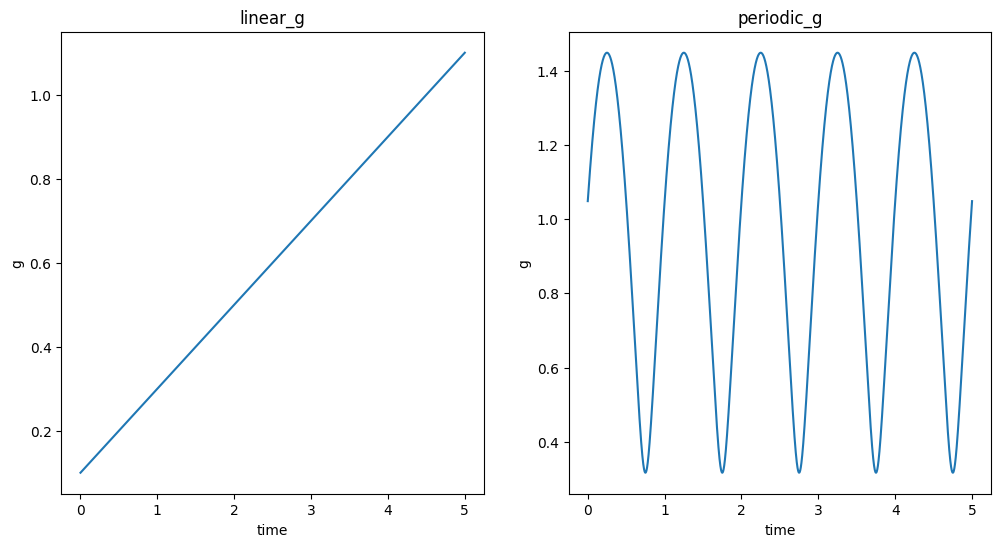

In [15]:
def linear_g(t,constant=0.2):
    """t - 1d np.ndarray or float
    Returns: 1d np.ndarray or float"""
    return 0.1+constant*t
def const_g(t,constant=2):
    return(t*0+constant)

def periodic_g(t):
    """t - 1d np.ndarray or float
    Returns: 1d np.ndarray or float"""
    return np.sqrt(np.sin(2*np.pi*t)+1.10)

def plot_g_random_drift(drift_func_list: List[Callable], min_t: float = 0.0, max_t: float = 5.0,n_grid_points: int = 10000):
    """Function to plot a random drift function g."""
    fig, axs = plt.subplots(1,len(drift_func_list),figsize=(len(drift_func_list)*6,6))
    time = np.linspace(min_t,max_t,n_grid_points)
    for idx,drift_func in enumerate(drift_func_list):
        axs[idx].plot(time,drift_func(time))
        axs[idx].set_title(drift_func.__name__)
        axs[idx].set_xlabel("time")
        axs[idx].set_ylabel("g")

plot_g_random_drift([linear_g,periodic_g])

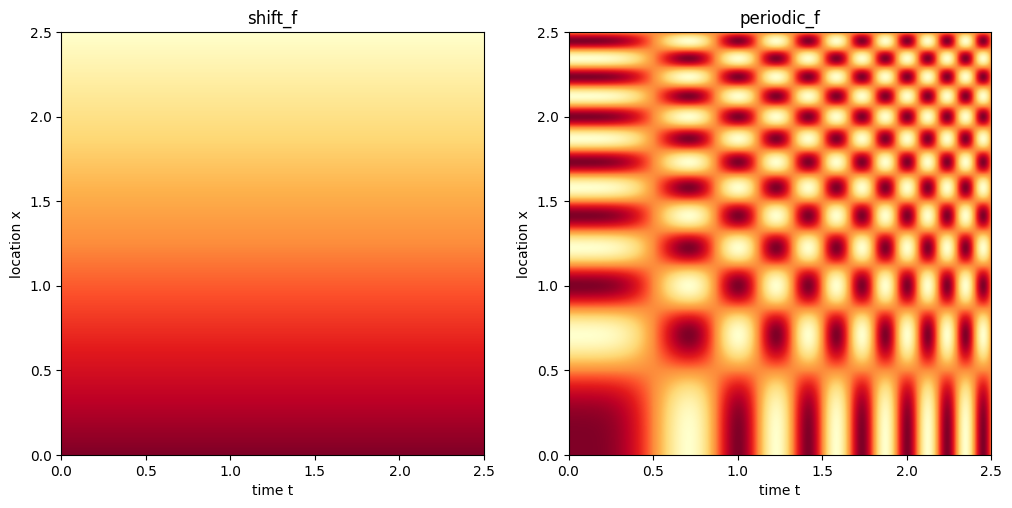

In [6]:

def shift_f(x,t,shift=4.0):
    """x - shape (n,k): a space coefficients 
       t - shape (n) or float: time coefficients"""
    return -(x-shift)

def constant_f(x,t,const=0):

    return(x*0+const)

def periodic_f(x,t):
    """x - shape (n,k): space coefficients 
       t - shape (n) or float: time coefficients"""

    if isinstance(t,float):
        return 2*np.cos(2*np.pi*t**2)*(np.cos(2*np.pi*x)) #*normalizer[:,None])
    else:
        return 2*np.cos(2*np.pi*t**2)[:,None]*(np.cos(2*np.pi*x**2)) #*normalizer[:,None])
    
def counter_h(x_t,X_R=3):
    return(X_R-x_t)

def plot_f_determ_drift(determ_func_list: List[Callable],
                min_t: float = 0.0, 
                max_t: float = 2.5, 
                min_x: float = 0.0,
                max_x: float = 2.5,
                n_grid_points: int = 1000,
                plot_contours=False):
    """Function to plot the function f(x,t) in an Ito-SDE."""
    time = np.linspace(min_t,max_t,n_grid_points)
    oned_grid = np.linspace(min_x, max_x, n_grid_points)
    twod_grid = np.array([[x,t] for t,x in product(time,oned_grid)])
    extent = [min_x, max_x, min_t, max_t]
    
    fig,axs = plt.subplots(1,len(determ_func_list),figsize=(6*len(determ_func_list),6))
    
    for idx, determ_func in enumerate(determ_func_list):
        derivative = determ_func(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
        axs[idx].imshow(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'))
        if plot_contours:
            axs[idx].contour(derivative.reshape(n_grid_points,n_grid_points).transpose(),interpolation='bilinear',origin='lower', extent = extent,color='black')
        axs[idx].set_title(determ_func.__name__)
        axs[idx].set_xlabel("time t")
        axs[idx].set_ylabel("location x")

plot_f_determ_drift([shift_f,periodic_f])

In [ ]:
def animate_ito_sde(f_drift: Callable, g_drift: Callable,h_drift: Callable,P_lambda=1, fpath_anim: str = None, n_steps: int = 100000, n_samples: int = 400,n_grid_points: int = 100, initial_dist:str ="normal", t_end=8.0,jump=False,exp_=False):
    """Function to animate and plot a 1d SDE over time."""
    if initial_dist == "normal":
        x_start = np.random.normal(size=n_samples).reshape(-1,1)#*0
    elif initial_dist == "uniform":
        x_start = np.random.uniform(size=n_samples).reshape(-1,1)#*0
    else:
        raise ValueError
    if jump:    
        x_traj,time_grid = run_JD_sde (f_drift,g_drift,h_drift,P_lambda,x_start=x_start,t_end=t_end,n_steps=n_steps)
        # x_traj=np.exp(x_traj) #aditya
    else:
        x_traj,time_grid = run_sde(f_drift,g_drift,x_start=x_start,t_end=t_end,n_steps=n_steps)
    # print(x_traj)
    x_traj = x_traj.squeeze()
    
    fig, axs = plt.subplots(2,1,figsize=(24,24))
    camera = Camera(fig)
    
    oned_grid = np.linspace(x_traj.min(), x_traj.max(), len(time_grid))
    twod_grid = np.array([[x,t] for t,x in product(time_grid,oned_grid)])
    extent = [time_grid.min(), time_grid.max(),x_traj.min(), x_traj.max()]
    derivative = f_drift(twod_grid[:,0].reshape(-1,1),twod_grid[:,1])
    derivative_plot = derivative.reshape(len(time_grid),len(time_grid)).transpose()
    
    g_drift_per_time = g_drift(time_grid)

    for idx in tqdm(range(1,len(x_traj),max(int(len(x_traj)/200),1))):
    
        #Plot evolution over time over deterministic drift:
        axs[0].imshow(derivative_plot,interpolation='bilinear',origin='lower', extent = extent, cmap=plt.get_cmap('YlOrRd'),aspect='auto')
        if idx>5:
            for idy in range(10):
                if exp_:
                    axs[0].plot(time_grid[:idx],np.exp(x_traj[:idx,idy].squeeze())) #,label=sample_labels)
                else:
                    axs[0].plot(time_grid[:idx],(x_traj[:idx,idy].squeeze())) #,label=sample_labels)
            if exp_:
                axs[0].plot(time_grid[:idx],np.exp(x_traj[:idx].squeeze().mean(axis=1)),color='black',linewidth=10)
            else:
                axs[0].plot(time_grid[:idx],(x_traj[:idx].squeeze().mean(axis=1)),color='black',linewidth=10)
                
        axs[0].set_title("Example trajectories (color=f)")

        #Plot distribution:
        if exp_:
            sns.kdeplot(np.exp(x_traj[idx]),ax=axs[1])
        else:
            sns.kdeplot((x_traj[idx]),ax=axs[1])
        axs[1].set_title("Distribution of X_t")

        #Plot random drift:
        # axs[2].plot(time_grid[:idx],g_drift_per_time[:idx])
        # axs[2].set_title("Random drift g")
        camera.snap()
        
    animation = camera.animate() # animation ready
    plt.close()
    return animation

In [8]:
RUN_ANIMATION = False
N_STEPS = 1000
N_SAMPLES = 1000

In [16]:
fpath = f"simple_sde.mp4"
animation = animate_ito_sde(shift_f,periodic_g,counter_h,P_lambda=1,n_steps=N_STEPS,n_samples=N_SAMPLES)
# # animation.save(fpath)

from matplotlib.animation import FFMpegWriter
from IPython.display import Video

animation.save("anim.mp4", writer=FFMpegWriter(fps=15))
Video("anim.mp4", embed=True)



0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
fpath = f"simple_sde2.mp4"
animation = animate_ito_sde(constant_f,const_g,counter_h,P_lambda=2,n_steps=N_STEPS,n_samples=N_SAMPLES,jump=True)
# # animation.save(fpath)

from matplotlib.animation import FFMpegWriter
from IPython.display import Video

animation.save("anim.mp4", writer=FFMpegWriter(fps=15))
Video("anim.mp4", embed=True)



0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [73]:

x_start = np.random.normal(size=1).reshape(-1,1)*0
x_traj,time_grid = run_JD_sde (constant_f,const_g,counter_h,5,x_start=x_start,t_end=10,n_steps=N_STEPS)


0it [00:00, ?it/s]

[[0.]] [[False]]
hello [[0.]]
[[0.0010001]] [[False]]
hello [[0.]]
[[0.0020002]] [[False]]
hello [[0.]]
[[0.0030003]] [[False]]
hello [[0.]]
[[0.0040004]] [[False]]
hello [[0.]]
[[0.0050005]] [[False]]
hello [[0.]]
[[0.0060006]] [[False]]
hello [[0.]]
[[0.0070007]] [[False]]
hello [[0.]]
[[0.0080008]] [[False]]
hello [[0.]]
[[0.0090009]] [[False]]
hello [[0.]]
[[0.010001]] [[False]]
hello [[0.]]
[[0.0110011]] [[False]]
hello [[0.]]
[[0.0120012]] [[False]]
hello [[0.]]
[[0.0130013]] [[False]]
hello [[0.]]
[[0.0140014]] [[False]]
hello [[0.]]
[[0.0150015]] [[False]]
hello [[0.]]
[[0.0160016]] [[False]]
hello [[0.]]
[[0.0170017]] [[False]]
hello [[0.]]
[[0.0180018]] [[False]]
hello [[0.]]
[[0.0190019]] [[False]]
hello [[0.]]
[[0.020002]] [[False]]
hello [[0.]]
[[0.0210021]] [[False]]
hello [[0.]]
[[0.0220022]] [[False]]
hello [[0.]]
[[0.0230023]] [[False]]
hello [[0.]]
[[0.0240024]] [[False]]
hello [[0.]]
[[0.0250025]] [[False]]
hello [[0.]]
[[0.0260026]] [[False]]
hello [[0.]]
[[0.027002

In [39]:
x_traj.shape

(10001, 5000, 1)

<Axes: ylabel='Density'>

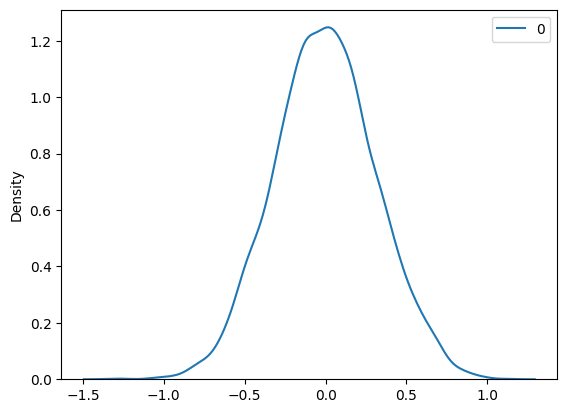

In [43]:
sns.kdeplot((x_traj[10000]))

In [17]:
np.exp(3)

20.085536923187668